In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/YLP

/content/drive/MyDrive/YLP


In [4]:
from RKNet import RKNet
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
import os

In [ ]:
batch_size = 128

shift = transforms.Normalize(
    mean=[0.5,0.5,0.5],
    std=[1.,1.,1.],
  )

transformTest = transforms.Compose(
    [transforms.ToTensor(),
     shift])



testSet = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transformTest)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=batch_size,
                                          shuffle=False)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [ ]:
# Load trained network
PATH = os.path.join('results','current_pdenet.pt')
net = torch.load(PATH)


net.eval()

RKNet(
  (dynamicBlocks): ModuleList(
    (0): rk4(
      (controlLayers): ModuleList(
        (0): DoubleSymLayer(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (act): ReLU()
          (normLayer): TvNorm()
          (convt): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): DoubleSymLayer(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (act): ReLU()
          (normLayer): TvNorm()
          (convt): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (2): DoubleSymLayer(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (act): ReLU()
          (normLayer): TvNorm()
          (convt): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (3): DoubleSymLayer(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1

In [ ]:
# Select device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Establish baseline accuracy

net = net.to(device)

correct = 0
total = 0
with torch.no_grad():
    for data in testLoader:
        # Load data to GPU
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # Feedforward through network
        outputs = net(images)
        # Choose predicted class as class with highest log-probability
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
control_acc = correct / total

Accuracy of the network on the 10000 test images: 84 %


In [ ]:
print(control_acc)

0.8471


In [ ]:
hue_results = np.zeros((21,3))
row = 0

for eps in np.arange(-0.5,0.51,0.05):
  
  # perturb the test images by their hue
  hueTransform = transforms.Compose(
    [lambda x: transforms.functional.adjust_hue(x,hue_factor=eps),
     transforms.ToTensor(),
     shift]
    )

  stabSet = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=hueTransform)
  stabLoader = torch.utils.data.DataLoader(stabSet, batch_size=batch_size,
                                            shuffle=False)
  
  correct = 0
  total = 0
  with torch.no_grad():
      for data in stabLoader:
          images, labels = data
          images = images.to('cuda')
          labels = labels.to('cuda')
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  acc = correct / total

  # Save results
  hue_results[row,] = np.array([eps,acc,acc/control_acc])
  row += 1

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [20]:
# Display the images provided, including eps = 0 in positive set, so need an extra row
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.figure(figsize=(8,30))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

def imshow_pos(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.figure(figsize=(9,30))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [17]:
# Saving images for use in report.
batch_size = 4

shift = transforms.Normalize(
    mean=[0.5,0.5,0.5],
    std=[1.,1.,1.],
  )

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
hue_images_neg = []
hue_images_zero = []
hue_images_pos = []

for eps in np.arange(-0.5,0.51,0.05):
  
  hueTransform = transforms.Compose(
    [lambda x: transforms.functional.adjust_hue(x,hue_factor=eps),
     transforms.ToTensor(),
     shift]
  )

  stabSet = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=hueTransform)
  stabLoader = torch.utils.data.DataLoader(stabSet, batch_size=batch_size,
                                            shuffle=False)
  
  dataiter = iter(stabLoader)
  images, labels = dataiter.next()

  # save images for later
  for im in images:
    if eps < 0:
      hue_images_neg.append(im)
    if eps == 0:
      hue_images_zero.append(im)
    if eps >= 0:
      hue_images_pos.append(im)
  
  # print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


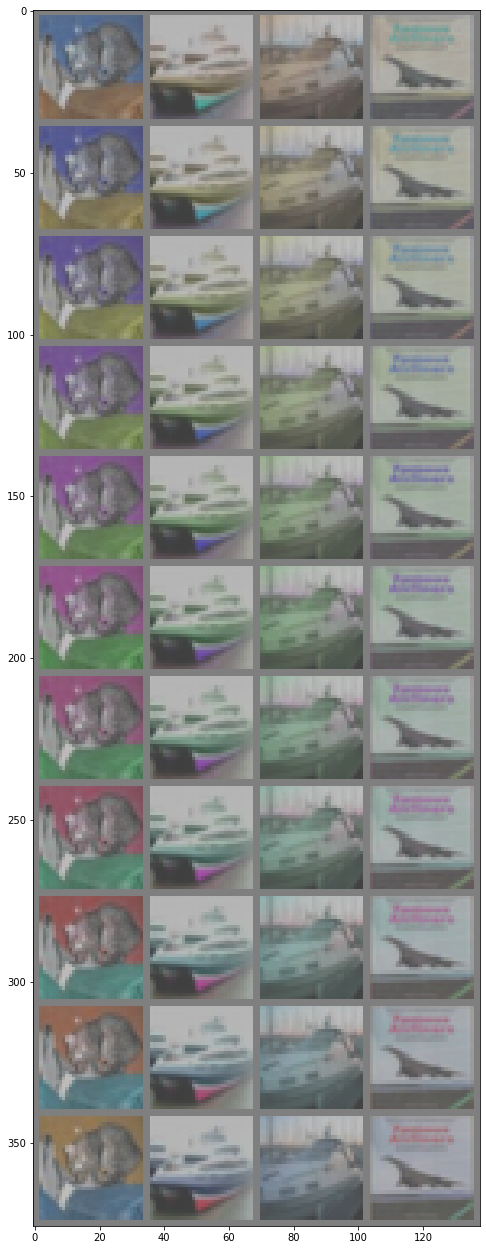

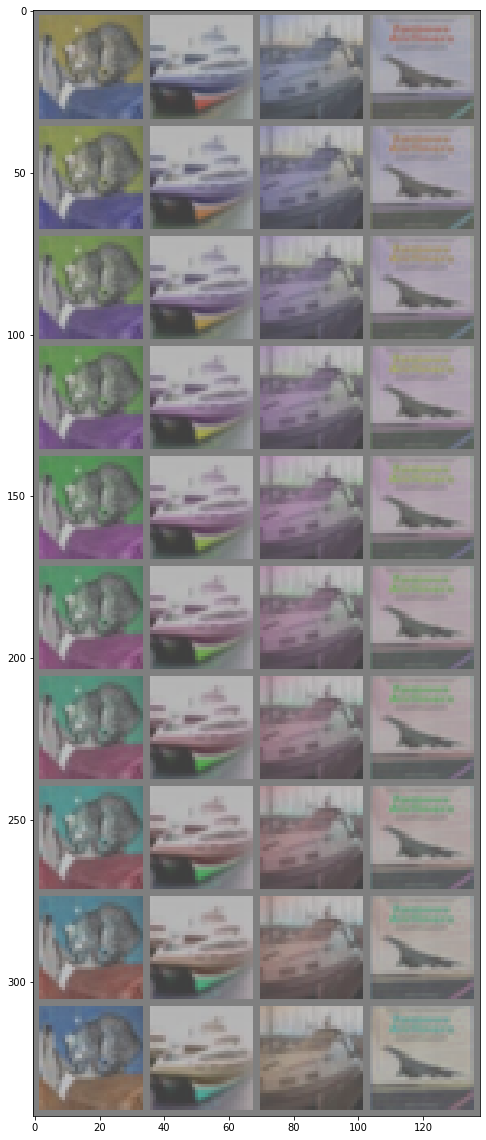

In [21]:
# Create hue perturbed images as seen in report
imshow(torchvision.utils.make_grid(hue_images_neg,nrow=4))
# imshow_zero(torchvision.utils.make_grid(hue_images_zero,nrow=4))
imshow_pos(torchvision.utils.make_grid(hue_images_pos,nrow=4))



In [ ]:
np.set_printoptions(suppress=True)
print(hue_results)

[[-0.5         0.6864      0.81029394]
 [-0.45        0.7105      0.83874395]
 [-0.4         0.7276      0.85893047]
 [-0.35        0.7382      0.87144375]
 [-0.3         0.7406      0.87427694]
 [-0.25        0.7425      0.87651989]
 [-0.2         0.7617      0.89918546]
 [-0.15        0.7847      0.92633691]
 [-0.1         0.8082      0.95407862]
 [-0.05        0.8341      0.98465352]
 [-0.          0.8472      1.00011805]
 [ 0.05        0.8287      0.97827883]
 [ 0.1         0.7802      0.92102467]
 [ 0.15        0.7369      0.8699091 ]
 [ 0.2         0.7039      0.83095266]
 [ 0.25        0.6788      0.80132216]
 [ 0.3         0.6672      0.78762838]
 [ 0.35        0.6743      0.79600992]
 [ 0.4         0.6813      0.8042734 ]
 [ 0.45        0.6778      0.80014166]
 [ 0.5         0.6823      0.8054539 ]]
[[-0.5         0.7612      0.89859521]
 [-0.45        0.7821      0.92326762]
 [-0.4         0.7994      0.94369024]
 [-0.35        0.813       0.95974501]
 [-0.3         0.8231   